In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [3]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [7]:
# decoding
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [8]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(x_train) + list(x_test)

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


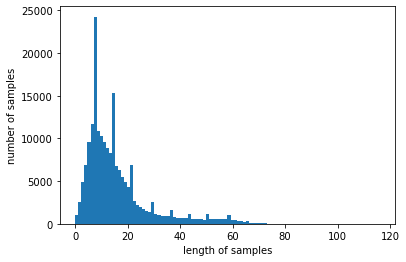

In [9]:
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
plt.clf()

plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# padding
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [13]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [14]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [15]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 5s 148ms/step - loss: 0.6875 - accuracy: 0.5817 - val_loss: 0.6672 - val_accuracy: 0.6902
Epoch 2/10
34/34 [==============================] - 1s 15ms/step - loss: 0.5924 - accuracy: 0.7554 - val_loss: 0.4906 - val_accuracy: 0.8080
Epoch 3/10
34/34 [==============================] - 1s 15ms/step - loss: 0.4169 - accuracy: 0.8268 - val_loss: 0.3818 - val_accuracy: 0.8354
Epoch 4/10
34/34 [==============================] - 0s 14ms/step - loss: 0.3503 - accuracy: 0.8535 - val_loss: 0.3603 - val_accuracy: 0.8439
Epoch 5/10
34/34 [==============================] - 0s 13ms/step - loss: 0.3251 - accuracy: 0.8650 - val_loss: 0.3548 - val_accuracy: 0.8470
Epoch 6/10
34/34 [==============================] - 0s 14ms/step - loss: 0.3102 - accuracy: 0.8719 - val_loss: 0.3533 - val_accuracy: 0.8491
Epoch 7/10
34/34 [==============================] - 1s 15ms/step - loss: 0.2993 - accuracy: 0.8773 - val_loss: 0.3568 - val_accuracy: 0.8473
Epoch 8/10
3

In [16]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3700 - accuracy: 0.8463
[0.3699801564216614, 0.8463290929794312]


In [17]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

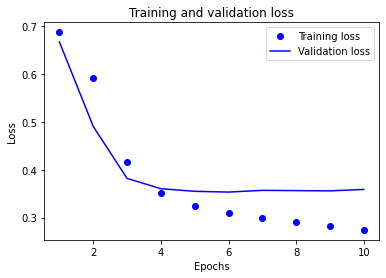

In [19]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

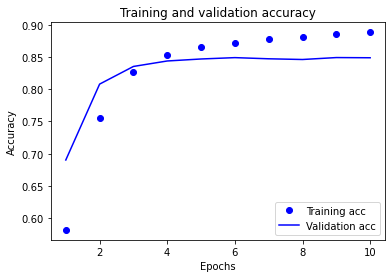

In [20]:
# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
pre_word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = pre_word2vec.wv.most_similar("강아지")
vector

[('고양이', 0.7290453314781189),
 ('거위', 0.7185634970664978),
 ('토끼', 0.7056223750114441),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.693433403968811),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.675035297870636),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512461304664612)]

In [22]:
pre_word2vec['강아지'].shape

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [23]:
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec:
        embedding_matrix[i] = pre_word2vec[index_to_word[i]]

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [29]:
# 모델 설계
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 3s 99ms/step - loss: 0.6866 - accuracy: 0.5401 - val_loss: 0.6698 - val_accuracy: 0.6093
Epoch 2/15
34/34 [==============================] - 3s 91ms/step - loss: 0.6255 - accuracy: 0.6704 - val_loss: 0.5836 - val_accuracy: 0.7079
Epoch 3/15
34/34 [==============================] - 3s 96ms/step - loss: 0.5467 - accuracy: 0.7406 - val_loss: 0.5120 - val_accuracy: 0.7641
Epoch 4/15
34/34 [==============================] - 3s 89ms/step - loss: 0.4795 - accuracy: 0.7865 - val_loss: 0.4549 - val_accuracy: 0.7957
Epoch 5/15
34/34 [==============================] - 3s 89ms/step - loss: 0.4268 - accuracy: 0.8157 - val_loss: 0.4156 - val_accuracy: 0.8175
Epoch 6/15
34/34 [==============================] - 3s 93ms/step - loss: 0.3906 - accuracy: 0.8350 - val_loss: 0.3895 - val_accuracy: 0.8311
Epoch 7/15
34/34 [==============================] - 3s 91ms/step - loss: 0.3682 - accuracy: 0.8462 - val_loss: 0.3869 - val_accuracy: 0.8372
Epoch 8/15
34

In [31]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3838 - accuracy: 0.8441
[0.3838472366333008, 0.8441320657730103]


In [32]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [33]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

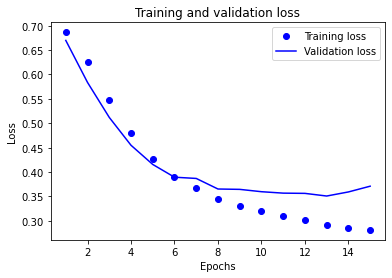

In [34]:
# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

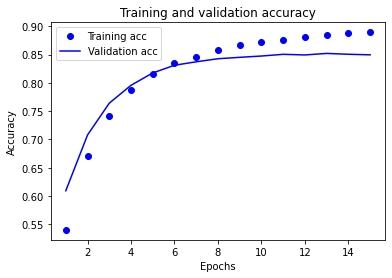

In [35]:
# Training and Validation accuracy
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()